In [53]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import warnings

from random import shuffle 
from tqdm import tqdm 
from PIL import Image
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm

%matplotlib inline

#Мы импортируем нужные лайбриари

In [54]:
in_path = 'chest_xray/'
# читаем путь

Resize, Normalize and Scale data


Класс Keras ImageDataGenerator позволяет изменять масштаб изображения, параметры изменения размера. здесь я применил увеличение изображения, а также преобразовал каждое изображение в двоичное (0 и 1). После инициализации генераторов мы можем определить поток наших данных. Изменение размера и масштабирование применяется к изображениям, чтобы сэкономить время на обучении. Увеличение данных помогает избежать переобучения. Увеличивая данные, мы будем вносить небольшие изменения в наши данные, чтобы у нас было больше данных без потери семантического значения. Дополнение происходит в параметрах метода ImageDataGenerator. 

In [57]:
# Здесь мы 
def extract_data(dimensions, batch_length):
    tgen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True) #создаем ImageDataGenerator для тест ,трэн и вал
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    tgen_final = tgen.flow_from_directory(directory=in_path+'train', target_size=(dimensions, dimensions), batch_size=batch_length, class_mode='binary', shuffle=True)
    test_gen = test_val_datagen.flow_from_directory(directory=in_path+'test', target_size=(dimensions, dimensions), batch_size=batch_length, class_mode='binary', shuffle=True)
        
    val_gen = ImageDataGenerator(rescale=1./255)
    Valid_gen = test_val_datagen.flow_from_directory(directory=in_path+'val', target_size=(dimensions, dimensions), batch_size=batch_length, class_mode='binary', shuffle=True)

    test_data = [] #создаем лист
    test_labels = []
    
    train_data = []
    train_labels = []
    
    val_data = []
    val_labels = []

    for normal_image in (os.listdir(in_path + 'test' + '/NORMAL/')):
        normal_image = plt.imread(in_path+'test'+'/NORMAL/'+normal_image) #читаем наши имэйджы
        normal_image = cv2.resize(normal_image, (dimensions, dimensions)) #изменяем размер
        normal_image = normal_image.astype('float32') / 255 #изменям дататайп
        label = 0
        test_data.append(normal_image) #добавляем в соответствующий лист
        test_labels.append(label)
    #проделоваем этот цикл для трэйн и валидэйт
    for pneumonia_image in (os.listdir(in_path + 'test' + '/PNEUMONIA/')):
        pneumonia_image = plt.imread(in_path+'test'+'/PNEUMONIA/'+pneumonia_image)
        pneumonia_image = cv2.resize(pneumonia_image, (dimensions, dimensions))
        pneumonia_image = pneumonia_image.astype('float32') / 255
        label = 1
        test_data.append(pneumonia_image)
        test_labels.append(label)

    for normal_image in (os.listdir(in_path + 'train' + '/NORMAL/')):
        if normal_image == '.DS_Store':
            continue
        normal_image = plt.imread(in_path+'train'+'/NORMAL/'+normal_image)
        normal_image = cv2.resize(normal_image, (dimensions, dimensions))
        normal_image = normal_image.astype('float32') / 255
        label = 0
        train_data.append(normal_image)
        train_labels.append(label)

    for pneumonia_image in (os.listdir(in_path + 'train' + '/PNEUMONIA/')):
        if pneumonia_image == '.DS_Store':
            continue
        pneumonia_image = plt.imread(in_path+'train'+'/PNEUMONIA/'+pneumonia_image)
        pneumonia_image = cv2.resize(pneumonia_image, (dimensions, dimensions))
        pneumonia_image = pneumonia_image.astype('float32') / 255
        label = 1
        train_data.append(pneumonia_image)
        train_labels.append(label)
        
        
    for normal_image in (os.listdir(in_path + 'val' + '/NORMAL/')):
        normal_image = plt.imread(in_path+'val'+'/NORMAL/'+normal_image)
        normal_image = cv2.resize(normal_image, (dimensions, dimensions))
        normal_image = normal_image.astype('float32') / 255
        label = 0
        test_data.append(normal_image)
        test_labels.append(label)

    for pneumonia_image in (os.listdir(in_path + 'val' + '/PNEUMONIA/')):
        pneumonia_image = plt.imread(in_path+'val'+'/PNEUMONIA/'+pneumonia_image)
        pneumonia_image = cv2.resize(pneumonia_image, (dimensions, dimensions))
        pneumonia_image = pneumonia_image.astype('float32') / 255
        label = 1
        val_data.append(pneumonia_image)
        val_labels.append(label)

    
    return tgen_final, test_gen, test_data, test_labels, train_data, train_labels,  val_data, val_labels

In [58]:
img_dims = 150
epochs = 3
batch_size = 10

train_gen, test_gen, test_data, test_labels, train_data, train_labels ,  val_data, val_labels = extract_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [61]:
train_gen.class_indices # Как видете наши имэйдж виде 0 и 1

{'NORMAL': 0, 'PNEUMONIA': 1}

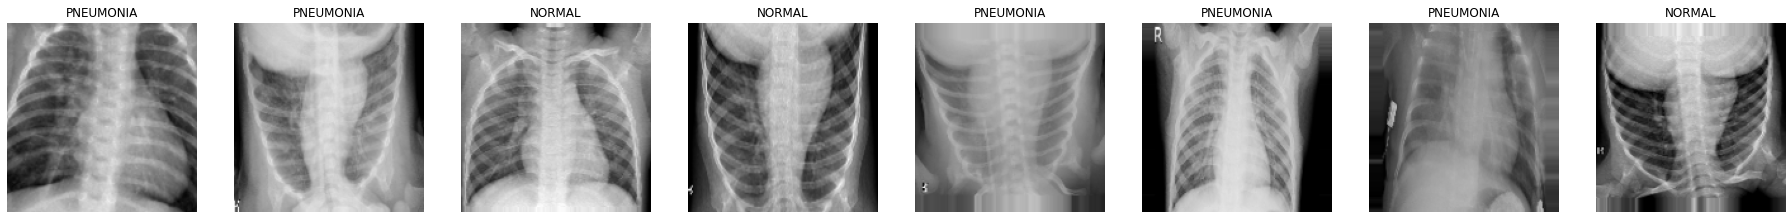

In [64]:
#Использовали матплотлиб чтобы показать нашего имэйджа с Нормал и Пневмония значениями
plt.figure(figsize=(40, 40))
for images, labels in train_gen:
    for i in range(8):        
        ax = plt.subplot(1, 10, i + 1)
        plt.imshow(images[i])        
        if int(labels[i]) == 1:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")                
        plt.axis("off")
    break

In [65]:
#Используется для сглаживания данных в матричной форме.
flat_train_data = [] #создаем flat 
flat_test_data = []
flat_val_data = []

for img in train_data: 
    flat_train_data.append(img.flatten())#добавляем к нашему листу влэт
    
for img in test_data: 
    flat_test_data.append(img.flatten())
    
for img in val_data: 
    flat_val_data.append(img.flatten())    
    

In [67]:
listed_train_data = []#создаем лист
listed_test_data = []
listed_val_data = []


for d in flat_train_data:
    listed_train_data.append(d.tolist()[:150*150])#здесь добавляем кнашему листу
    
for d in flat_test_data:
    listed_test_data.append(d.tolist()[:150*150])

for d in flat_val_data:
    listed_val_data.append(d.tolist()[:150*150])

In [68]:
train_labels_mini = train_labels
test_labels_mini = test_labels

# val_labels_mini = val_labels


In [ ]:
#SVM придикт

In [69]:
clf = svm.SVC()
prediction = clf.fit(listed_train_data, train_labels_mini)

In [71]:
correctlyPredicted = 0
fp = 0
tp = 0
fn = 0
tn = 0

for ind in range(len(listed_test_data)): 
    pred = clf.predict([listed_test_data[ind]])
    real = test_labels_mini[ind]
    if real == 1 and pred == 1:
        tp += 1
    if real == 1 and pred == 0:
        fn += 1
    if real == 0 and pred == 1:
        fp += 1
    if real == 0 and pred == 0:
        tn += 1
    if pred == real:
        correctlyPredicted += 1

acc = correctlyPredicted/float(len(listed_test_data))
print("TEST DATA________________________")
print("Accuracy: {}".format(acc))
print("Confusion matrix: f_p = {}, t_p = {}, f_n = {}, t_n = {}".format(fp, tp, fn, tn))

prec = tp/(tp+fp)*100
rec = tp/(tp+fn)*100
print("Precision: {}, recall: {}".format(prec, rec))

TEST DATA________________________
Accuracy: 0.7579113924050633
Confusion matrix: f_p = 148, t_p = 385, f_n = 5, t_n = 94
Precision: 72.23264540337712, recall: 98.71794871794873


In [72]:
correctlyPredicted = 0
fp = 0
tp = 0
fn = 0
tn = 0

for ind in range(len(listed_train_data)): 
    pred = clf.predict([listed_train_data[ind]])
    real = train_labels_mini[ind]
    if real == 1 and pred == 1:
        tp += 1
    if real == 1 and pred == 0:
        fn += 1
    if real == 0 and pred == 1:
        fp += 1
    if real == 0 and pred == 0:
        tn += 1
    if pred == real:
        correctlyPredicted += 1

acc = correctlyPredicted/float(len(listed_train_data))
print("TRAIN DATA________________________")
print("Accuracy: {}".format(acc))
print("Confusion matrix: f_p = {}, t_p = {}, f_n = {}, t_n = {}".format(fp, tp, fn, tn))

prec = tp/(tp+fp)*100
rec = tp/(tp+fn)*100
print("Precision: {}, recall: {}".format(prec, rec))

TRAIN DATA________________________
Accuracy: 0.9831288343558282
Confusion matrix: f_p = 48, t_p = 3835, f_n = 40, t_n = 1293
Precision: 98.76384238990471, recall: 98.96774193548387
